<a href="https://colab.research.google.com/github/fumio125/ou_dip/blob/master/ou_dip_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ディジタル画像処理 第4回

画素の変換と幾何変換「パノラマ画像を作ってみよう」

In [ ]:
import cv2
import numpy as np  # PythonのOpenCVでは、画像はnumpyのarrayとして管理される
from google.colab.patches import cv2_imshow # colab内で画像表示関数がうまく動かないので、パッチが提供されている

# Googleドライブへのマウント
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/ou_dip/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/ou_dip


In [ ]:
# imgをrefに張り合わせることを考える
ref = cv2.imread("pano_ref.jpg") # ベースとなる画像（BGR）
src = cv2.imread("pano_src.jpg") # 変換する画像（BGR）

pts_ref = np.float32([[923,156],[1281,143],[1276,760],[916,745]]) # refの点(x', y')
pts_src = np.float32([[88,163],[438,190],[437,760],[78,782]])  # srcの点(x, y)

H = cv2.getPerspectiveTransform(pts_src,pts_ref)  # 最小二乗法によるホモグラフィ行列の推定（img -> refへの変換）

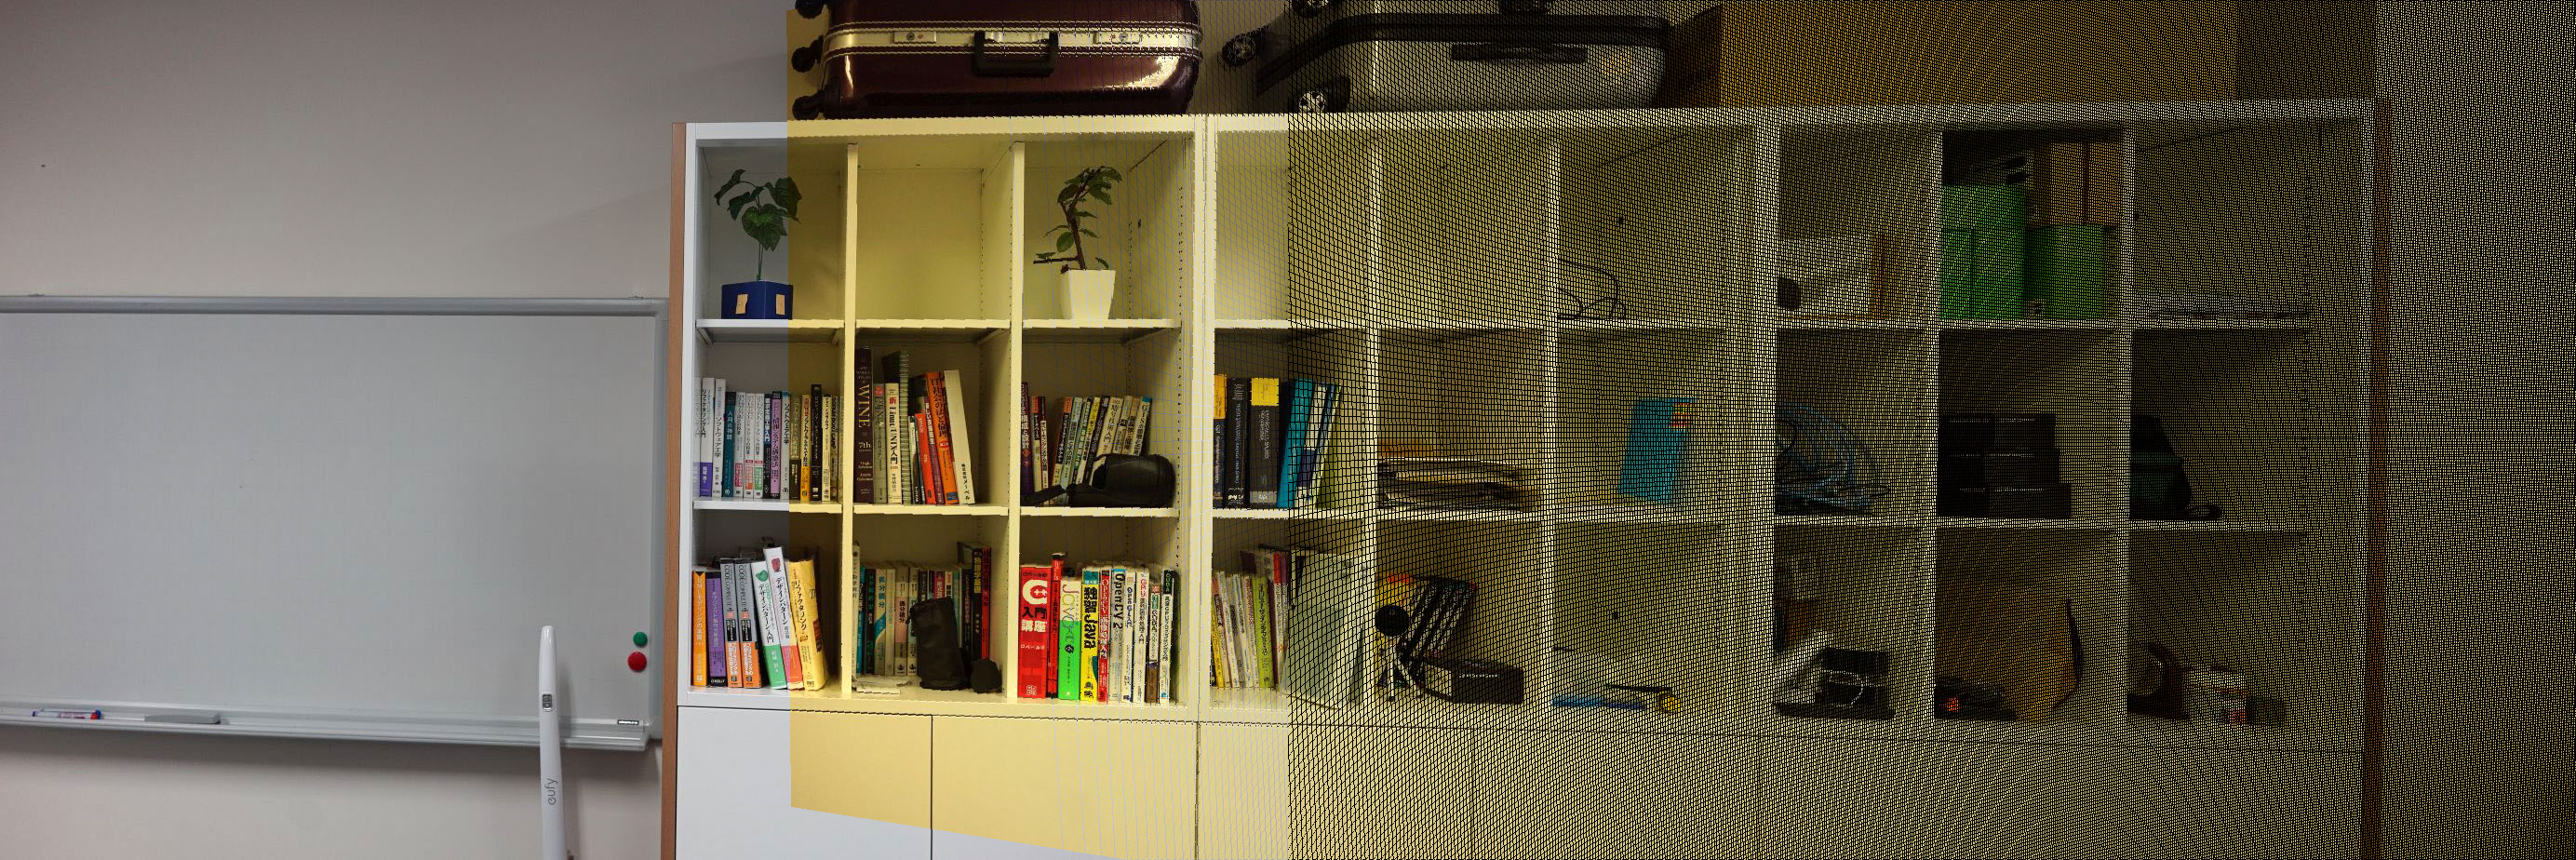

In [ ]:
# CAUTION: 以下はあくまで仕組みを学習するための例。
# 実用上は、二重forループなどできるだけ書かず、関数を呼べるなら呼ぶべき（Appendix参照）

# 順変換による画像生成例
# 全画素に画素値を埋められず、穴が空いていることがわかる：逆変換が必要！
dst_forward = np.zeros((src.shape[0],src.shape[1]*2,3), dtype=np.uint8) # 横幅2倍の画像を生成(縦src.shape[0],横src.shape[1],3ch)
dst_forward[0:ref.shape[0], 0:ref.shape[1], :] = ref # 最初に、refの画素値を先に入れておく（部分配列の操作）。3次元目は色なので、そのまま(:)

for src_y in range(src.shape[0]):
  for src_x in range(src.shape[1]):
    src_xyw = np.float32([src_x, src_y, 1]) # 同次座標
    dst_xyw = H.dot(src_xyw)  # 変換
    dst_x = dst_xyw[0]/dst_xyw[2] # 出力画像のX
    dst_y = dst_xyw[1]/dst_xyw[2] # 出力画像のY

    if dst_x < 0 or dst_y < 0 or dst_x > dst_forward.shape[1]-1 or dst_y > dst_forward.shape[0]-1:  # 画像の外側を参照しないようにする
      continue
    
    dst_forward[int(dst_y+0.5)][int(dst_x+0.5)] = src[src_y][src_x]   # 対応する画素から画素値をコピー 

cv2_imshow(dst_forward) # 表示

In [ ]:
# 課題：逆変換による画像生成
# レベル：Basic（最近傍法による補間）
# レベル：Advanced（バイリニア補間）
# 注意：勉強のため、imshow, imread, imwrite以外のOpenCVの関数 (cv2で始まる) は、ここでは使わないように

dst = np.zeros((src.shape[0],src.shape[1]*2,3), dtype=np.uint8) # 横幅2倍の画像を生成(縦src.shape[0],横src.shape[1],3ch)
dst[0:ref.shape[0], 0:ref.shape[1], :] = ref # 最初に、refの画素値を先に入れておく（部分配列の操作）。3次元目は色なので、そのまま(:)
H_inv = np.linalg.inv(H)  # 逆行列の計算

# 画像生成処理
## ヒント：基本的には、順変換と同様のことをH_invを使ってやれば良い

cv2_imshow(dst) # 表示

In [ ]:
# 課題：refとdstの間の重複部分の画素値を使った色補正
# レベル：Advanced　以下の流れでやると良い
# 注意：勉強のため、imshow, imread, imwrite以外のOpenCVの関数 (cv2で始まる) は、ここでは使わないように

# 1) refと変換後dstの重複領域をマスクとして計算


# 2) src, refそれぞれの重複領域の画素値をnumpy arrayとして作成（3*N、nは重複領域の面積）
## ヒント：img[mask]とすると、maskがTrueの要素を取り出せる


# 3) src -> refへの色補正行列の計算（線形最小二乗法を解く。講義スライド参照）
## ヒント：擬似逆行列の計算は np.linalg.pinv(X) 


# 4) 変換行列による画素値の変換


# 5) 表示
## サンプルの例では、周辺減光の影響で完全には色が一致しない。
## 重複領域をうまくアルファブレンディングすることで境目を目立たなくすることもできる。興味があれば試してみよう。


In [ ]:
# Appendix: OpenCVにおけるワーピング関数（デフォルトでは逆変換の後バイリニア補間）
# https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87
dst_opencv = cv2.warpPerspective(src, H, (src.shape[1]*2,src.shape[0]))

cv2_imshow(dst_opencv) # 表示